In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os

import math


from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import datetime as dt

2023-03-13 17:56:42.044550: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-13 17:56:42.107903: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-13 17:56:42.108935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:56:42.972079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
df = pd.read_csv('final_dataset22.csv')
df
#tf.convert_to_tensor(df)

# Read Dataset

In [2]:

fname = 'final_dataset22.csv'

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
lines.pop()

header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))




['', 'Unnamed: 0', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol', 'ignore', 'ao', 'kama', 'ppo', 'pvo', 'roc', 'rsi', 'stochrsi', 'stoch', 'tsi', 'uo', 'wri', 'accdist', 'cmf', 'emv', 'fi', 'mfi', 'nvi', 'obv', 'smaemv', 'vpt', 'vwap', 'atr', 'ulcer', 'bbh', 'bbl', 'bbhi', 'bbli', 'bbmavg', 'bb_pb', 'bb_wb', 'dchb', 'dclb', 'dcmb', 'dcpb', 'dcwb', 'kchb', 'kclb', 'kchbi', 'kclbi', 'kcmb', 'kcpb', 'kcwb', 'adx', 'adx_neg', 'adx_pos', 'aroon_up', 'aroon_down', 'cci', 'dpo', 'kst', 'kst_sig', 'ema', 'ichimoku_a', 'ichimoku_b', 'ichimoku_base_line', 'ichimoku_conversion_line', 'macd', 'macd_diff', 'macd_signal', 'mi', 'sma', 'wma', 'stc', 'trix', 'psar_down_indicator', 'psar_up_indicator', 'vi_pos', 'vi_neg', 'ALU', 'WHEAT', 'XCU', 'BRENTOIL', 'COFFEE', 'SOYBEAN', 'NG', 'NI', 'RICE', 'XAU', 'IRD', 'SUGAR', 'ETHANOL', 'CORN', 'COTTON', 'TIN', 'ZNC']
525530


In [16]:
close = np.zeros( (len(lines),1) )
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    #print(values)
    close[i] = values[5]
    raw_data[i, :] = values[:]
        


In [8]:
close

array([[47271.88],
       [47289.97],
       [47300.72],
       ...,
       [16519.37],
       [16521.85],
       [16521.38]])

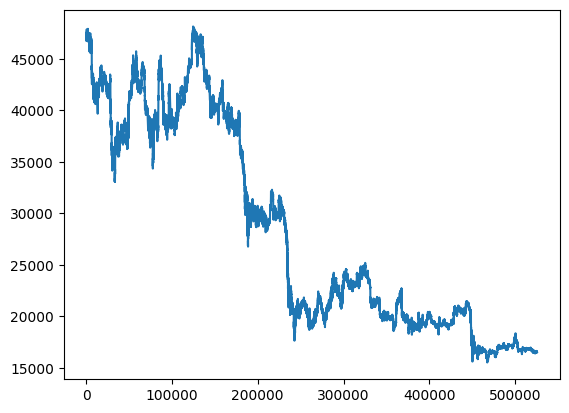

In [9]:
plt.plot(range(len(close)), close)

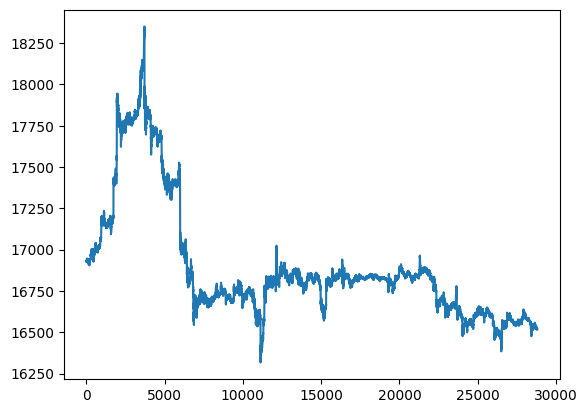

In [10]:
# print last x days
days = 20
x = days * 24 * 60
close[:-x].shape
plt.plot(range(x), close[-x:])

# Prepare Datasets

In [17]:
num_train_samples = int(0.5 * len(raw_data))  # Train
num_val_samples = int(0.25 * len(raw_data))   # Validation
num_test_samples = len(raw_data) - num_train_samples - num_val_samples  # Test
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 262765
num_val_samples: 131382
num_test_samples: 131383


In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

/tmp/ipykernel_1621902/2392611981.py:4: RuntimeWarning: invalid value encountered in divide
  raw_data /= std


In [18]:

# hours to be taken account in the past for sequence_lenght 
hours = 48
hours_delay = 48

sampling_rate = 30
sequence_length = hours
delay = sampling_rate * (sequence_length + (hours_delay) - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_length=sequence_length,
                    shuffle=True, # Shouldn't the shuffle be set to 0?
                    seed=33,
                    batch_size=batch_size,
                    start_index=0,
                    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_length=sequence_length,
                    shuffle=True,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples,
                    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_length=sequence_length,
                    shuffle=True,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples + num_val_samples)

In [19]:
samples.shape

TensorShape([206, 48, 98])

In [20]:
targets.shape

TensorShape([206, 1])

In [21]:
i =0
for samples, targets in train_dataset:
    i=i+1
    print("samples_shape:", samples.shape)
    print("targets shape:", targets.shape)
    #break
    
print(i)

2023-03-13 18:07:07.790105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [261326]
	 [[{{node Placeholder/_8}}]]
2023-03-13 18:07:07.790750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [261326]
	 [[{{node Placeholder/_28}}]]


samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (256, 1)
samples_shape: (256, 48, 98)
targets shape: (2

# First ML Model

In [9]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(8, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("cryptocurrency-market-prediction-project/data-analysis", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,epochs=10,validation_data=val_dataset,callbacks=callbacks)

model = keras.models.load_model("cryptocurrency-market-prediction-project/data-analysis")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
1012/1021 [============================>.] - ETA: 0s - loss: nan - mae: nan

2023-03-13 17:57:41.814443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [129943]
	 [[{{node Placeholder/_28}}]]
2023-03-13 17:57:41.815352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [131382,98]
	 [[{{node Placeholder/_0}}]]


1021/1021 [==============================] - 24s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/10
1021/1021 [==============================] - 18s 18ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/10
1021/1021 [==============================] - 19s 18ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/10
1021/1021 [==============================] - 18s 18ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/10
1021/1021 [==============================] - 18s 18ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/10
1021/1021 [==============================] - 18s 18ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/10
1021/1021 [==============================] - 18s 18ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/10
1021/1021 [==============================] - 20s 19ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/10
1021/102

2023-03-13 18:00:41.498877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [128533,98]
	 [[{{node Placeholder/_0}}]]
2023-03-13 18:00:41.499502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


497/497 [==============================] - 6s 11ms/step - loss: nan - mae: nan
Test MAE: nan


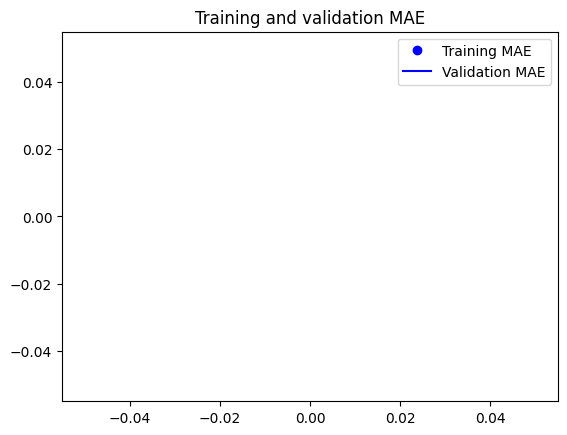

In [10]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# Try 2

In [4]:
df

df['DATE'] = df['datetime']/1000

df['DATE'] = df['DATE'].apply(dt.datetime.utcfromtimestamp)

#df['DATE'] = df['DATE'].dt.strftime("%Y-%m-%d")

df

,Unnamed: 0.1,Unnamed: 0,datetime,open,high,low,close,volume,close_time,qav,...,RICE,XAU,IRD,SUGAR,ETHANOL,CORN,COTTON,TIN,ZNC,DATE
0,71,71,1641017460000,47249.44,47281.68,47249.44,47271.88,10.37408,1641017519999,4.903711e+05,...,14.632537,0.000547,4147.926037,0.189924,2.136423,5.928399,1.129187,1.222731,0.102048,2022-01-01 06:11:00
1,72,72,1641017520000,47271.87,47290.00,47271.87,47289.97,4.11304,1641017579999,1.944688e+05,...,14.632537,0.000547,4147.926037,0.189924,2.136423,5.928399,1.129187,1.222731,0.102048,2022-01-01 06:12:00
2,73,73,1641017580000,47289.96,47320.00,47287.60,47300.72,13.45235,1641017639999,6.363889e+05,...,14.632537,0.000547,4147.926037,0.189924,2.136423,5.928399,1.129187,1.222731,0.102048,2022-01-01 06:13:00
3,74,74,1641017640000,47300.71,47324.42,47293.01,47307.04,6.17338,1641017699999,2.920746e+05,...,14.632537,0.000547,4147.926037,0.189924,2.136423,5.928399,1.129187,1.222731,0.102048,2022-01-01 06:14:00
4,75,75,1641017700000,47307.03,47307.04,47258.73,47259.14,4.41853,1641017759999,2.088964e+05,...,14.632537,0.000547,4147.926037,0.189924,2.136423,5.928399,1.129187,1.222731,0.102048,2022-01-01 06:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525525,525596,525596,1672548960000,16521.42,16521.93,16516.49,16518.76,83.64312,1672549019999,1.381688e+06,...,18.000000,0.000548,4800.000000,0.200500,2.161000,6.785000,0.830000,19391.166190,3012.500000,2023-01-01 04:56:00
525526,525597,525597,1672549020000,16518.76,16519.22,16517.03,16517.41,48.86392,1672549079999,8.071365e+05,...,18.000000,0.000548,4800.000000,0.200500,2.161000,6.785000,0.830000,19391.166190,3012.500000,2023-01-01 04:57:00
525527,525598,525598,1672549080000,16517.39,16520.64,16517.28,16519.37,61.07865,1672549139999,1.008950e+06,...,18.000000,0.000548,4800.000000,0.200500,2.161000,6.785000,0.830000,19391.166190,3012.500000,2023-01-01 04:58:00
525528,525599,525599,1672549140000,16519.37,16522.81,16511.92,16521.85,173.39683,1672549199999,2.864058e+06,...,18.000000,0.000548,4800.000000,0.200500,2.161000,6.785000,0.830000,19391.166190,3012.500000,2023-01-01 04:59:00


In [5]:
df['DATE'].dtype

dtype('<M8[ns]')

In [8]:
# Split into training, validation and test datasets.
# Since it's timeseries we should do it by date.
test_cutoff_date = df['DATE'].max() - dt.timedelta(days=30)
val_cutoff_date = test_cutoff_date - dt.timedelta(days=30)

df_test = df[df['DATE'] > test_cutoff_date]
df_val = df[(df['DATE'] > val_cutoff_date) & (df['DATE'] <= test_cutoff_date)]
df_train = df[df['DATE'] <= val_cutoff_date]

#check out the datasets
print('Test dates: {} to {}'.format(df_test['DATE'].min(), df_test['DATE'].max()))
print(df_test['datetime'].count())
print('\n')
print('Validation dates: {} to {}'.format(df_val['DATE'].min(), df_val['DATE'].max()))
print(df_val['datetime'].count())
print('\n')   
print('Train dates: {} to {}'.format(df_train['DATE'].min(), df_train['DATE'].max()))
print(df_train['datetime'].count())
print('\n')

Test dates: 2022-12-02 05:01:00 to 2023-01-01 05:00:00
43200


Validation dates: 2022-11-02 05:01:00 to 2022-12-02 05:00:00
43200


Train dates: 2022-01-01 06:11:00 to 2022-11-02 05:00:00
439130




In [10]:
def create_ts_files(dataset, 
                    start_index, 
                    end_index, 
                    history_length, 
                    step_size, 
                    target_step, 
                    num_rows_per_file, 
                    data_folder):
    assert step_size > 0
    assert start_index >= 0
    
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    
    time_lags = sorted(range(target_step+1, target_step+history_length+1, step_size), reverse=True)
    col_names = [f'x_lag{i}' for i in time_lags] + ['y']
    start_index = start_index + history_length
    if end_index is None:
        end_index = len(dataset) - target_step
    
    rng = range(start_index, end_index)
    num_rows = len(rng)
    num_files = math.ceil(num_rows/num_rows_per_file)
    
    # for each file.
    print(f'Creating {num_files} files.')
    for i in range(num_files):
        filename = f'{data_folder}/ts_file{i}.pkl'
        
        if i % 10 == 0:
            print(f'{filename}')
            
        # get the start and end indices.
        ind0 = i*num_rows_per_file + start_index
        ind1 = min(ind0 + num_rows_per_file, end_index)
        data_list = []
        
        # j in the current timestep. Will need j-n to j-1 for the history. And j + target_step for the target.
        for j in range(ind0, ind1):
            indices = range(j-1, j-history_length-1, -step_size)
            data = dataset[sorted(indices) + [j+target_step]]
            
            # append data to the list.
            data_list.append(data)

        df_ts = pd.DataFrame(data=data_list, columns=col_names)
        df_ts.to_pickle(filename)
            
    return len(col_names)-1

In [13]:
bitcoin_close = df_train['close'].values

# Scaled to work with Neural networks.
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_close_scaled = scaler.fit_transform(bitcoin_close.reshape(-1, 1)).reshape(-1, )

history_length = 30*24*60  # The history length in minutes.
step_size = 10  # The sampling rate of the history. Eg. If step_size = 1, then values from every minute will be in the history.
                #                                       If step size = 10 then values every 10 minutes will be in the history.
target_step = 10  # The time step in the future to predict. Eg. If target_step = 0, then predict the next timestep after the end of the history period.
                  #                                             If target_step = 10 then predict 10 timesteps the next timestep (11 minutes after the end of history).

# The csv creation returns the number of rows and number of features. We need these values below.
num_timesteps = create_ts_files(bitcoin_close_scaled,
                                start_index=0,
                                end_index=None,
                                history_length=history_length,
                                step_size=step_size,
                                target_step=target_step,
                                num_rows_per_file=5000,
                                data_folder='ts_data')

Creating 80 files.
ts_data/ts_file0.pkl
ts_data/ts_file10.pkl
ts_data/ts_file20.pkl
ts_data/ts_file30.pkl
ts_data/ts_file40.pkl
ts_data/ts_file50.pkl
ts_data/ts_file60.pkl
ts_data/ts_file70.pkl


In [3]:
#
# So we can handle loading the data in chunks from the hard drive instead of having to load everything into memory.
# 
# The reason we want to do this is so we can do custom processing on the data that we are feeding into the LSTM.
# LSTM requires a certain shape and it is tricky to get it right.
#
class TimeSeriesLoader:
    def __init__(self, ts_folder, filename_format):
        self.ts_folder = ts_folder
        
        # find the number of files.
        i = 0
        file_found = True
        while file_found:
            filename = self.ts_folder + '/' + filename_format.format(i)
            file_found = os.path.exists(filename)
            if file_found:
                i += 1
                
        self.num_files = i
        self.files_indices = np.arange(self.num_files)
        self.shuffle_chunks()
        
    def num_chunks(self):
        return self.num_files
    
    def get_chunk(self, idx):
        assert (idx >= 0) and (idx < self.num_files)
        
        ind = self.files_indices[idx]
        filename = self.ts_folder + '/' + filename_format.format(ind)
        df_ts = pd.read_pickle(filename)
        num_records = len(df_ts.index)
        
        features = df_ts.drop('y', axis=1).values
        target = df_ts['y'].values
        
        # reshape for input into LSTM. Batch major format.
        features_batchmajor = np.array(features).reshape(num_records, -1, 1)
        return features_batchmajor, target
    
    # this shuffles the order the chunks will be outputted from get_chunk.
    def shuffle_chunks(self):
        np.random.shuffle(self.files_indices)

# First LSTM

In [4]:
ts_inputs = tf.keras.Input(shape=(num_timesteps, 1))

NameError: name 'num_timesteps' is not defined

In [5]:
x = layers.LSTM(units=10)(ts_inputs)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

NameError: name 'ts_inputs' is not defined

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

In [ ]:
model.summary()